In [1]:
#add project directory to python path
import sys
sys.path.append("..")
#import standard packages
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline
from default import PROJECT_DIRECTORY, DATA_DIRECTORY

# Clustering

In [2]:
"""
load halo catalogue
"""

import h5py
from astropy.table import Table

filepath = DATA_DIRECTORY
filename = 'mdr1_fof_va.hdf5'
f = h5py.File(filepath+filename,'r')
dset = f['data']

#put data table into an Astropy Table 
d = {key: dset[key] for key in dset.dtype.names}
halo_table = Table(d)
print(halo_table.keys())

#set cosmology of simulation
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.27) #MDR1 cosmology
Lbox = np.array([1000.0]*3)

#define halo core velocities
m_part = 8.721*10**9 #particle mass
n_part = int(10**13/m_part) #number of particles in 10^13 Msol halo

#use z-component of velocities
core_velocity_keys = ['vz_central_ptcl','vz_inner01','vz_inner10',
                      'vz_inner20','vz_inner30','vz_inner40',
                      'vz_inner50','vz_inner60','vz_inner70',
                      'vz_inner80','vz_inner90', 'vz_all']
cores_percentages = np.array([1/n_part,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

['vx_inner50', 'vx_inner70', 'rowid', 'vz_inner30', 'vy_inner50', 'vz_inner70', 'vy_inner10', 'vz_inner50', 'vy_inner70', 'vy_inner30', 'vx_inner90', 'haloid', 'vx', 'vy', 'vz', 'vx_central_ptcl', 'size', 'vz_std', 'vy_inner90', 'vz_inner80', 'vz_all', 'vx_inner20', 'vx_inner60', 'vx_inner01', 'vx_std', 'vy_inner40', 'vx_inner40', 'vz_inner40', 'vz_inner20', 'vz_inner60', 'vz_central_ptcl', 'vy_inner60', 'vy_all', 'vz_inner10', 'vy_central_ptcl', 'vx_inner80', 'vy_std', 'vz_inner90', 'vx_all', 'vy_inner80', 'vy_inner20', 'vx_inner30', 'mass', 'vz_inner01', 'y', 'x', 'z', 'vx_inner10', 'vy_inner01']


## Caclulate the TPCF

In [3]:
"""
put haloes in redshift space
"""

from halotools.mock_observables import return_xyz_formatted_array
from halotools.mock_observables import s_mu_tpcf

halo_velocity_key = 'vz_inner10'

coords = return_xyz_formatted_array(halo_table['x'],halo_table['y'],halo_table['z'],
                                    velocity=halo_table[halo_velocity_key],
                                    period=Lbox, velocity_distortion_dimension='z')

In [4]:
"""
calculate the tpcf in s and mu bins
"""

#Define s bins
s_bins = np.logspace(0,np.log10(100),50)
s_bin_centers = (s_bins[:-1]+s_bins[1:])/(2.0)

#Define mu bins
mu_bins = np.linspace(0.0,1.0,50) 
mu_bin_centers = (mu_bins[:-1]+mu_bins[1:])/(2.0)
    
#Calculate TPCF
import time
start = time.time()
result = s_mu_tpcf(coords, s_bins=s_bins, mu_bins=mu_bins, period=Lbox, num_threads=4)
print("time to compute: ", time.time()-start)

time to compute:  23.3535840511


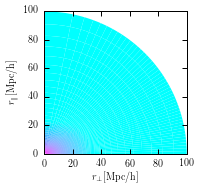

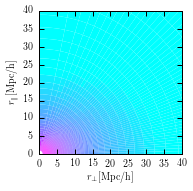

In [18]:
"""
plot the tpcf in s and mu space
"""
from utils import s_mu_tpcf_patches

#remove neagtive correlations to make plotting nicer
result_prime = np.fabs(result)

#get path collection
p = s_mu_tpcf_patches(np.log10(result_prime), s_bins, mu_bins, vmin=-1, vmax=1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3, 3.3))
fig.subplots_adjust(hspace=0, wspace=0, left=0.2, right=0.8, bottom=0.2, top=0.8)
ax.add_collection(p)
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel(r'$r_{\perp} [{\rm Mpc/h}]$')
ax.set_ylabel(r'$r_{\parallel} [{\rm Mpc/h}]$')
plt.show()

p = s_mu_tpcf_patches(np.log10(result_prime), s_bins, mu_bins, vmin=-1, vmax=1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3, 3.3))
fig.subplots_adjust(hspace=0, wspace=0, left=0.2, right=0.8, bottom=0.2, top=0.8)
ax.add_collection(p)
ax.set_xlim([0,40])
ax.set_ylim([0,40])
ax.set_xlabel(r'$r_{\perp} [{\rm Mpc/h}]$')
ax.set_ylabel(r'$r_{\parallel} [{\rm Mpc/h}]$')
plt.show()

## Caclulate the Multipoles of the TPCF

In [60]:
"""
calculate the multipoles of the tpcf
"""

from halotools.mock_observables import tpcf_multipole

tpcf_l_0 = tpcf_multipole(result_prime, mu_bins, order=0)
tpcf_l_2 = tpcf_multipole(result_prime, mu_bins, order=2)
tpcf_l_4 = tpcf_multipole(result_prime, mu_bins, order=4)

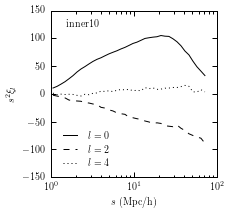

In [61]:
"""
plot the multipoles
"""

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
l1, = plt.plot(s_bin_centers, tpcf_l_0*s_bin_centers**2, '-', color='black')
l2, = plt.plot(s_bin_centers, tpcf_l_2*s_bin_centers**2, '--', color='black')
l3, = plt.plot(s_bin_centers, tpcf_l_4*s_bin_centers**2, ':', color='black')
plt.ylabel(r'$s^2\xi_l$')
plt.xlabel(r'$s ~({\rm Mpc/h})$')
plt.xscale('log')
plt.xlim([1,100])
plt.ylim([-150,150])
plt.legend([l1,l2,l3],[r'$l=0$',r'$l=2$',r'$l=4$'], fontsize=10, loc='lower left', frameon=False)
plt.text(1.5, 120, halo_velocity_key.split('_')[1], fontsize=10)

plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'multipoles_'+halo_velocity_key
fig.savefig(filepath + filename + '.pdf', dpi=300)
fig.savefig(filepath + filename + '.png', dpi=300)

In [89]:
"""
save multipoles in tabular form
"""

from astropy.table import Table

t = Table([s_bin_centers, tpcf_l_0, tpcf_l_2, tpcf_l_4], names=('s', 'l=0', 'l=2', 'l=4'))

filepath = DATA_DIRECTORY
filename = 'multipoles_'+halo_velocity_key
t.write(filepath + filename + '.dat', format='ascii')

## Calculate jackknife errors

In [ ]:
"""
calculate jackknife errors on the tpcf
"""
from halotools.mock_observables import cuboid_subvolume_labels

#define randoms
Nran = 2*10**6
randoms = np.random.random((Nran, 3))*Lbox

#get suubvolume labels
Nsub = np.array([3]*3)
jackknife_random_labels =  cuboid_subvolume_labels(randoms, Nsub, Lbox)[0]
jackknife_labels =  cuboid_subvolume_labels(coords, Nsub, Lbox)[0]

#Define s bins
s_bins = np.logspace(0,np.log10(100),50)
s_bin_centers = (s_bins[:-1]+s_bins[1:])/(2.0)

#Define mu bins
mu_bins = np.linspace(0.0,1.0,100) 
mu_bin_centers = (mu_bins[:-1]+mu_bins[1:])/(2.0)

jackknife_results = np.zeros((np.prod(Nsub), len(s_bins)-1, len(mu_bins)-1))
for i in range(1, np.prod(Nsub)+1):
    print(i)
    mask_1 = (jackknife_labels != i)
    mask_2 = (jackknife_random_labels != i)
    jackknife_results[i-1,:,:] = s_mu_tpcf(coords[mask_1], randoms=randoms[mask_2],
                                           s_bins=s_bins, mu_bins=mu_bins,
                                           period=Lbox, num_threads=4)

1


In [41]:
"""
calculate multipoles for jackknife samples
"""
from halotools.mock_observables import tpcf_multipole

tpcf_l_0_jackknife = np.zeros((np.prod(Nsub),len(s_bins)-1))
tpcf_l_2_jackknife = np.zeros((np.prod(Nsub),len(s_bins)-1))
tpcf_l_4_jackknife = np.zeros((np.prod(Nsub),len(s_bins)-1))
for i in range(0, np.prod(Nsub)-1):
    tpcf_l_0_jackknife[i,:] = tpcf_multipole(jackknife_results[i,:], mu_bins, order=0)
    tpcf_l_2_jackknife[i,:] = tpcf_multipole(jackknife_results[i,:], mu_bins, order=2)
    tpcf_l_4_jackknife[i,:] = tpcf_multipole(jackknife_results[i,:], mu_bins, order=4)

#calculate jackknife errors
tpcf_l_0_cov = np.matrix(np.cov(tpcf_l_0_jackknife.T))
tpcf_l_2_cov = np.matrix(np.cov(tpcf_l_2_jackknife.T))
tpcf_l_4_cov = np.matrix(np.cov(tpcf_l_4_jackknife.T))

tpcf_l_0_mean = np.mean(tpcf_l_0_jackknife, axis=0)
tpcf_l_2_mean = np.mean(tpcf_l_2_jackknife, axis=0)
tpcf_l_4_mean = np.mean(tpcf_l_4_jackknife, axis=0)

tpcf_l_0_err = np.sqrt(np.diagonal(tpcf_l_0_cov))
tpcf_l_2_err = np.sqrt(np.diagonal(tpcf_l_2_cov))
tpcf_l_4_err = np.sqrt(np.diagonal(tpcf_l_4_cov))

In [42]:
(tpcf_l_0_mean-tpcf_l_0_err)*s_bin_centers**2

array([  6.60237455,   8.126781  ,   9.40398946,  12.40655447,
        14.91534907,  17.52964357,  20.49912778,  23.89859521,
        25.89549002,  28.36547464,  30.76629204,  32.53622436,
        34.04047933,  35.85734907,  37.80063758,  39.36222303,
        40.74398047,  42.48095808,  43.74559944,  45.52861317,
        47.36207743,  48.56880127,  50.2894495 ,  51.96277171,
        52.58214526,  53.40204584,  53.58412976,  54.82543213,
        54.44410778,  54.04321461,  51.58045437,  49.09558986,
        45.23132855,  40.20392959,  36.46901915,  30.6210181 ,
        24.54367474,  20.27218589,  14.71402346])

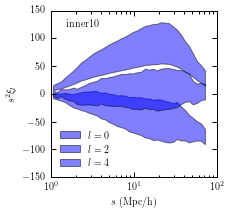

In [43]:
"""
plot the multipoles with error regions
"""

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
y1 = (tpcf_l_0_mean-tpcf_l_0_err)*s_bin_centers**2
y2 = (tpcf_l_0_mean+tpcf_l_0_err)*s_bin_centers**2
l1 = plt.fill_between(s_bin_centers,y1,y2, alpha=0.5)
y1 = (tpcf_l_2_mean-tpcf_l_0_err)*s_bin_centers**2
y2 = (tpcf_l_2_mean+tpcf_l_0_err)*s_bin_centers**2
l2 = plt.fill_between(s_bin_centers,y1,y2, alpha=0.5)
y1 = (tpcf_l_4_mean-tpcf_l_0_err)*s_bin_centers**2
y2 = (tpcf_l_4_mean+tpcf_l_0_err)*s_bin_centers**2
l3 = plt.fill_between(s_bin_centers,y1,y2, alpha=0.5)
plt.ylabel(r'$s^2\xi_l$')
plt.xlabel(r'$s ~({\rm Mpc/h})$')
plt.xscale('log')
plt.xlim([1,100])
plt.ylim([-150,150])
plt.legend([l1,l2,l3],[r'$l=0$',r'$l=2$',r'$l=4$'], fontsize=10, loc='lower left', frameon=False)
plt.text(1.5, 120, halo_velocity_key.split('_')[1], fontsize=10)

plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'multipoles_'+halo_velocity_key
fig.savefig(filepath + filename + '.pdf', dpi=300)
fig.savefig(filepath + filename + '.png', dpi=300)

## Calculate TPCF in $r_{\perp}$ and $r_{\parallel}$ space

In [90]:
"""
Calculate the TPCF in redshift space
"""

from halotools.mock_observables import rp_pi_tpcf

#define perpendicular bins
rp_bins = np.linspace(0.001,50,50)
rp_bin_centers = (rp_bins[:-1]+rp_bins[1:])/(2.0)

#define parallel bins
pi_bins = np.linspace(0.001,50,50) 
pi_bin_centers = (pi_bins[:-1]+pi_bins[1:])/(2.0)
    
#calculate TPCF
import time
start = time.time()
result = rp_pi_tpcf(coords, rp_bins=rp_bins, pi_bins=pi_bins, period=Lbox, num_threads=4)
print("time to compute: ", time.time()-start)

time to compute:  25.3033130169


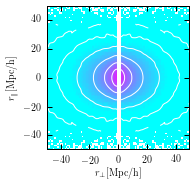

In [91]:
"""
plot the tpcf in redshift space
"""

from scipy.ndimage.filters import gaussian_filter

mrp_bin_centers = np.hstack((-1.0*rp_bin_centers[::-1],rp_bin_centers))
mpi_bin_centers = np.hstack((-1.0*pi_bin_centers[::-1],pi_bin_centers))

mxi_2d = np.hstack((np.fliplr(result),result))
mmxi_2d = np.vstack((np.flipud(mxi_2d),mxi_2d))
    
im = np.flipud(np.log10(mmxi_2d).T)
sim = gaussian_filter(im,1.0)
X, Y = np.meshgrid(mrp_bin_centers, mpi_bin_centers)
    
fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(3.3, 3.3))
fig.subplots_adjust(hspace=0, wspace=0, left=0.2, right=0.8, bottom=0.2, top=0.8)
m = ax.imshow(im,interpolation='nearest',aspect='equal',vmin=-1, vmax=1, cmap='cool',\
                extent=[mrp_bin_centers[0],mrp_bin_centers[-1],mpi_bin_centers[0],mpi_bin_centers[-1]])

#add contour lines
ax.contour(X,Y,sim,colors='white',linewidths=1, linestyles='solid')

#put a white box over the inner 1 Mpc
import matplotlib.patches as patches
ax.add_patch(
    patches.Rectangle(
        (-1,-50),   # (x,y)
        2,         # width
        100,       # height
        color='white')
                 )

#add colorbar
cax = fig1.add_axes([0.82, 0.2, 0.03, 0.6])
cbar = fig1.colorbar(m, cax=cax, ticks=[-1.0, -0.5, 0, 0.5, 1.0])
cbar.ax.set_ylabel(r'$\log(\xi(r_{\perp},r_{\parallel}))$',labelpad=-4)
ax.set_xlabel(r'$r_{\perp} [{\rm Mpc/h}]$')
ax.set_ylabel(r'$r_{\parallel} [{\rm Mpc/h}]$')
plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'rp_pi_tpcf_' + halo_velocity_key
fig.savefig(filepath + filename + '.pdf', dpi=300)
fig.savefig(filepath + filename + '.png', dpi=300)

## Compare multipoles using different core definitions

In [7]:
"""
compare multipoles using different core definitions
"""

from astropy.table import Table

filepath = DATA_DIRECTORY

#use z-component of velocities
core_keys = ['vz_inner01','vz_inner10',
             'vz_inner20','vz_inner30','vz_inner40',
             'vz_inner50','vz_inner60','vz_inner70',
             'vz_inner80','vz_inner90', 'vz_all']
cores = np.array([0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

filename = 'multipoles_'+core_keys[1]
t_10 = Table.read(filepath + filename + '.dat', format='ascii')

filename = 'multipoles_'+core_keys[2]
t_20 = Table.read(filepath + filename + '.dat', format='ascii')

filename = 'multipoles_'+core_keys[3]
t_30 = Table.read(filepath + filename + '.dat', format='ascii')

filename = 'multipoles_'+core_keys[4]
t_40 = Table.read(filepath + filename + '.dat', format='ascii')

filename = 'multipoles_'+core_keys[5]
t_50 = Table.read(filepath + filename + '.dat', format='ascii')

filename = 'multipoles_'+core_keys[6]
t_60 = Table.read(filepath + filename + '.dat', format='ascii')

filename = 'multipoles_'+core_keys[7]
t_70 = Table.read(filepath + filename + '.dat', format='ascii')

filename = 'multipoles_'+core_keys[8]
t_80 = Table.read(filepath + filename + '.dat', format='ascii')

filename = 'multipoles_'+core_keys[9]
t_90 = Table.read(filepath + filename + '.dat', format='ascii')

filename = 'multipoles_'+core_keys[10]
t_0 = Table.read(filepath + filename + '.dat', format='ascii')

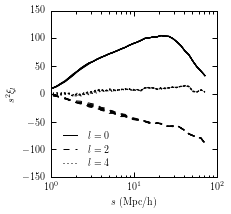

In [9]:
"""
plot the multipoles
"""

s_bin_centers = t_10['s']

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

l1, = plt.plot(s_bin_centers, t_10['l=0']*s_bin_centers**2, '-', color='black')
l2, = plt.plot(s_bin_centers, t_10['l=2']*s_bin_centers**2, '--', color='black')
l3, = plt.plot(s_bin_centers, t_10['l=4']*s_bin_centers**2, ':', color='black')

l1, = plt.plot(s_bin_centers, t_20['l=0']*s_bin_centers**2, '-', color='black')
l2, = plt.plot(s_bin_centers, t_20['l=2']*s_bin_centers**2, '--', color='black')
l3, = plt.plot(s_bin_centers, t_20['l=4']*s_bin_centers**2, ':', color='black')

l1, = plt.plot(s_bin_centers, t_30['l=0']*s_bin_centers**2, '-', color='black')
l2, = plt.plot(s_bin_centers, t_30['l=2']*s_bin_centers**2, '--', color='black')
l3, = plt.plot(s_bin_centers, t_30['l=4']*s_bin_centers**2, ':', color='black')

l1, = plt.plot(s_bin_centers, t_40['l=0']*s_bin_centers**2, '-', color='black')
l2, = plt.plot(s_bin_centers, t_40['l=2']*s_bin_centers**2, '--', color='black')
l3, = plt.plot(s_bin_centers, t_40['l=4']*s_bin_centers**2, ':', color='black')

l1, = plt.plot(s_bin_centers, t_50['l=0']*s_bin_centers**2, '-', color='black')
l2, = plt.plot(s_bin_centers, t_50['l=2']*s_bin_centers**2, '--', color='black')
l3, = plt.plot(s_bin_centers, t_50['l=4']*s_bin_centers**2, ':', color='black')

l1, = plt.plot(s_bin_centers, t_60['l=0']*s_bin_centers**2, '-', color='black')
l2, = plt.plot(s_bin_centers, t_60['l=2']*s_bin_centers**2, '--', color='black')
l3, = plt.plot(s_bin_centers, t_60['l=4']*s_bin_centers**2, ':', color='black')

l1, = plt.plot(s_bin_centers, t_70['l=0']*s_bin_centers**2, '-', color='black')
l2, = plt.plot(s_bin_centers, t_70['l=2']*s_bin_centers**2, '--', color='black')
l3, = plt.plot(s_bin_centers, t_70['l=4']*s_bin_centers**2, ':', color='black')

l1, = plt.plot(s_bin_centers, t_80['l=0']*s_bin_centers**2, '-', color='black')
l2, = plt.plot(s_bin_centers, t_80['l=2']*s_bin_centers**2, '--', color='black')
l3, = plt.plot(s_bin_centers, t_80['l=4']*s_bin_centers**2, ':', color='black')

l1, = plt.plot(s_bin_centers, t_90['l=0']*s_bin_centers**2, '-', color='black')
l2, = plt.plot(s_bin_centers, t_90['l=2']*s_bin_centers**2, '--', color='black')
l3, = plt.plot(s_bin_centers, t_90['l=4']*s_bin_centers**2, ':', color='black')

l1, = plt.plot(s_bin_centers, t_0['l=0']*s_bin_centers**2, '-', color='black')
l2, = plt.plot(s_bin_centers, t_0['l=2']*s_bin_centers**2, '--', color='black')
l3, = plt.plot(s_bin_centers, t_0['l=4']*s_bin_centers**2, ':', color='black')

plt.ylabel(r'$s^2\xi_l$')
plt.xlabel(r'$s ~({\rm Mpc/h})$')
plt.xscale('log')
plt.xlim([1,100])
plt.ylim([-150,150])
plt.legend([l1,l2,l3],[r'$l=0$',r'$l=2$',r'$l=4$'], fontsize=10, loc='lower left', frameon=False)

plt.show()

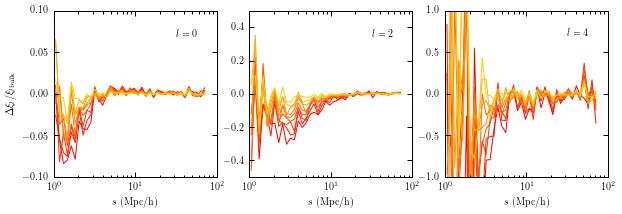

In [43]:
s_bin_centers = t_10['s']

from matplotlib import cm 
colors = cm.autumn(1.0*np.arange(10)/10.0)

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(11.0,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9, wspace=0.2)

ax=axes[0]
ax.text(10.0**1.5, 0.07, r'$l=0$')
l1, = ax.plot(s_bin_centers, (t_10['l=0']-t_0['l=0'])/t_0['l=0'], '-', color=colors[0])
l1, = ax.plot(s_bin_centers, (t_20['l=0']-t_0['l=0'])/t_0['l=0'], '-', color=colors[1])
l1, = ax.plot(s_bin_centers, (t_30['l=0']-t_0['l=0'])/t_0['l=0'], '-', color=colors[2])
l1, = ax.plot(s_bin_centers, (t_40['l=0']-t_0['l=0'])/t_0['l=0'], '-', color=colors[3])
l1, = ax.plot(s_bin_centers, (t_50['l=0']-t_0['l=0'])/t_0['l=0'], '-', color=colors[4])
l1, = ax.plot(s_bin_centers, (t_60['l=0']-t_0['l=0'])/t_0['l=0'], '-', color=colors[5])
l1, = ax.plot(s_bin_centers, (t_70['l=0']-t_0['l=0'])/t_0['l=0'], '-', color=colors[6])
l1, = ax.plot(s_bin_centers, (t_80['l=0']-t_0['l=0'])/t_0['l=0'], '-', color=colors[7])
l1, = ax.plot(s_bin_centers, (t_90['l=0']-t_0['l=0'])/t_0['l=0'], '-', color=colors[8])
ax.set_ylabel(r'$\Delta \xi_l/\xi_{l \rm bulk}$')
ax.set_xlabel(r'$s ~({\rm Mpc/h})$')
ax.set_xscale('log')
ax.set_ylim([-0.1,0.1])


ax=axes[1]
ax.text(10.0**1.5, 0.35, r'$l=2$')
l2, = ax.plot(s_bin_centers, (t_10['l=2']-t_0['l=2'])/t_0['l=2'], '-', color=colors[0])
l2, = ax.plot(s_bin_centers, (t_20['l=2']-t_0['l=2'])/t_0['l=2'], '-', color=colors[1])
l2, = ax.plot(s_bin_centers, (t_30['l=2']-t_0['l=2'])/t_0['l=2'], '-', color=colors[2])
l2, = ax.plot(s_bin_centers, (t_40['l=2']-t_0['l=2'])/t_0['l=2'], '-', color=colors[3])
l2, = ax.plot(s_bin_centers, (t_50['l=2']-t_0['l=2'])/t_0['l=2'], '-', color=colors[4])
l2, = ax.plot(s_bin_centers, (t_60['l=2']-t_0['l=2'])/t_0['l=2'], '-', color=colors[5])
l2, = ax.plot(s_bin_centers, (t_70['l=2']-t_0['l=2'])/t_0['l=2'], '-', color=colors[6])
l2, = ax.plot(s_bin_centers, (t_80['l=2']-t_0['l=2'])/t_0['l=2'], '-', color=colors[7])
l2, = ax.plot(s_bin_centers, (t_90['l=2']-t_0['l=2'])/t_0['l=2'], '-', color=colors[8])
ax.set_xlabel(r'$s ~({\rm Mpc/h})$')
ax.set_xscale('log')
ax.set_ylim([-0.5,0.5])


ax=axes[2]
ax.text(10.0**1.5, 0.7, r'$l=4$')
l3, = ax.plot(s_bin_centers, (t_10['l=4']-t_0['l=4'])/t_0['l=4'], '-', color=colors[0])
l3, = ax.plot(s_bin_centers, (t_20['l=4']-t_0['l=4'])/t_0['l=4'], '-', color=colors[1])
l3, = ax.plot(s_bin_centers, (t_30['l=4']-t_0['l=4'])/t_0['l=4'], '-', color=colors[2])
l3, = ax.plot(s_bin_centers, (t_40['l=4']-t_0['l=4'])/t_0['l=4'], '-', color=colors[3])
l3, = ax.plot(s_bin_centers, (t_50['l=4']-t_0['l=4'])/t_0['l=4'], '-', color=colors[4])
l3, = ax.plot(s_bin_centers, (t_60['l=4']-t_0['l=4'])/t_0['l=4'], '-', color=colors[5])
l3, = ax.plot(s_bin_centers, (t_70['l=4']-t_0['l=4'])/t_0['l=4'], '-', color=colors[6])
l3, = ax.plot(s_bin_centers, (t_80['l=4']-t_0['l=4'])/t_0['l=4'], '-', color=colors[7])
l3, = ax.plot(s_bin_centers, (t_90['l=4']-t_0['l=4'])/t_0['l=4'], '-', color=colors[8])
ax.set_xlabel(r'$s ~({\rm Mpc/h})$')
ax.set_xscale('log')
ax.set_xlim([1,100])
ax.set_ylim([-1,1])

plt.show()